In [ ]:
#CEL PROJEKTU: CELEM PROJEKTU JEST SPRAWDZENIE STOPNIA SKUTECZNOŚCI WYBRANYCH MODELI/ALGORYTMÓW UCZENIA MASZYNOWEGO DO PRZEWIDYWANIA WARTOŚCI DANYCH SZEREGU CZASOWEGO NA PODSTAWIE SPÓŁKI AKCYJNEJ GOOGLE/ALPHABET

In [ ]:
pip install yfinance

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import yfinance as yf

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [239]:
# IMPORT DANYCH Z WYKORZYSTANIEM YFINANCE

data = yf.download('GOOGL', index_col = 0, squeeze = True, parse_dates=['Date'])

#WYSWIETLENIE DANYCH

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
...,...,...,...,...,...,...
2023-01-17,92.059998,92.250000,90.050003,91.290001,91.290001,32602400
2023-01-18,92.139999,92.800003,90.639999,91.120003,91.120003,29116700
2023-01-19,90.720001,93.610001,90.629997,93.050003,93.050003,37000400


In [240]:
#WNIOSEK: KOLUMNY W ZAIMPORTOWANYCH REPREZENTUJĄ ODPOWIEDNIO: CENĘ OTWARCIA W DANEJ SESJI, MAKSYMALNĄ CENĘ PODCZAS TRWANIA SESJI, MINIMALNĄ CENĘ W DANEJ SESJI, CENĘ ZAMKNIĘCIA W DANEJ SESJI ORAZ WOLUMEN TRANSAKCYJNY, WIERSZE/INDEKSY REPREZENTUJĄ DZIEŃ HANDLOWY


In [241]:
#WYŚWIETLENIE WYMIARÓW DANYCH

data.shape

(4639, 6)

In [242]:
#WNIOSEK: DANE SKŁADAJĄ SIĘ Z 6CIU KOLUMN ORAZ 4629 OBSERWACJI

In [243]:
#SPRAWDZENIE CZY W DANYCH ZNAJDUJĄ SIĘ BRAKUJĄCE WARTOŚCI

data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [244]:
#WNIOSEK: ZAIMPORTOWANE DANE SĄ CZYSTE - NIE WYSTĘPUJĄ WARTOŚCI BRAKUJĄCE

In [245]:
#FILTROWANIE ANALIZOWANYCH DANYCH - NAS INTERESUJE CENA ZAMKNIECIA

data = data['Close']

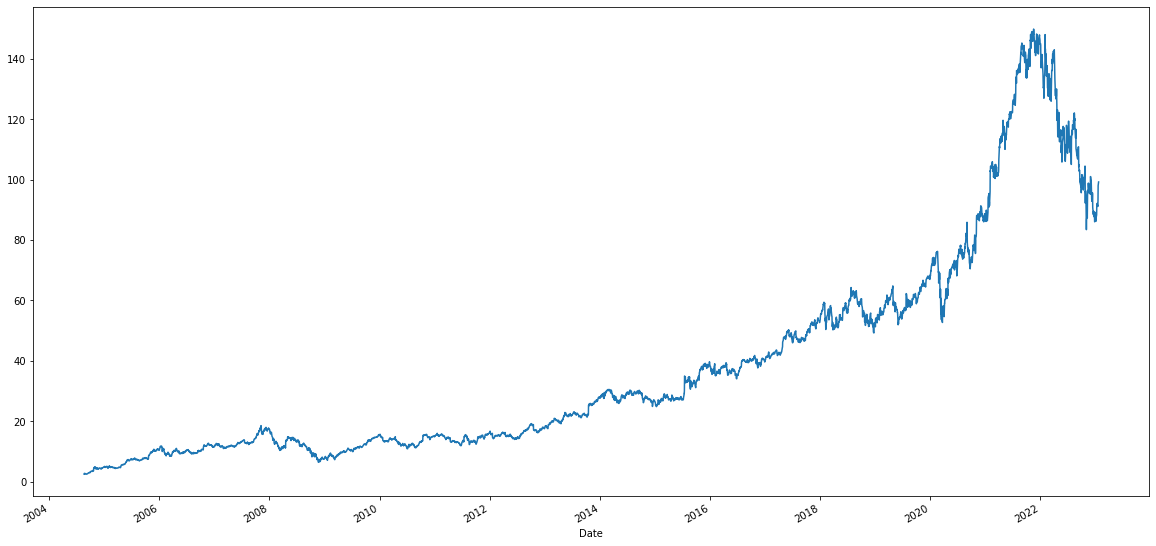

In [246]:
#NARYSOWANIE WYKRESU CENY ZAMKNIECIA W CZASIE

plt.figure(figsize=(20, 10))
data.plot()
plt.show()

In [247]:
from statsmodels.tsa.stattools import adfuller

In [248]:
#ZAIMPORTOWANIE FUNKCJI SPRAWDZAJĄCEJ STACJONARNOŚĆ SZEREGU CZASOWEGO

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()#.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,10));
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

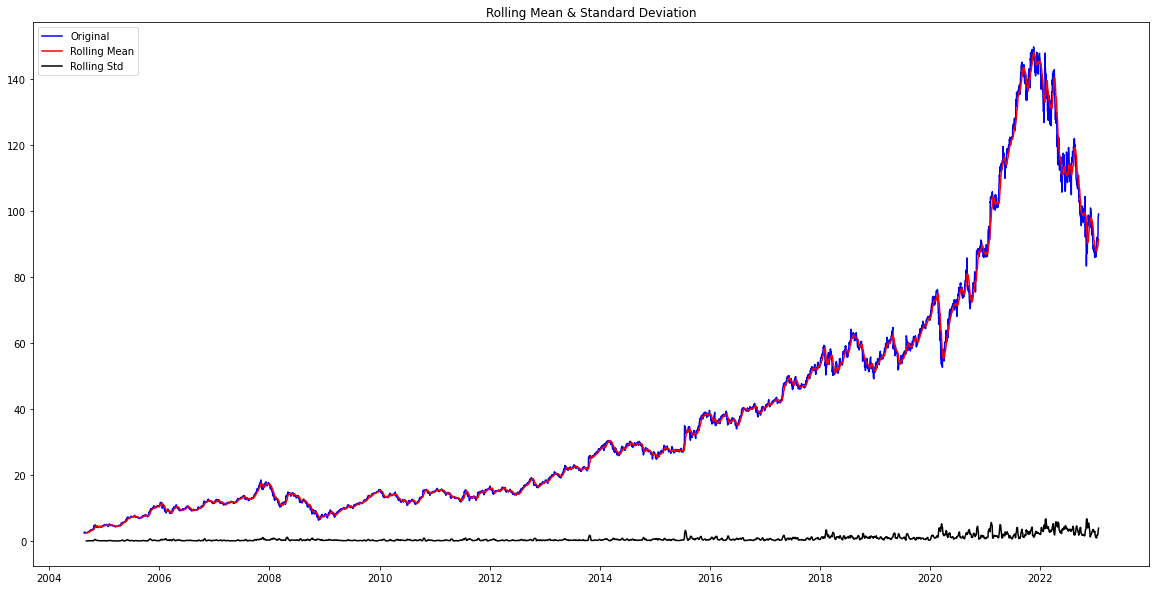

Results of Dickey-Fuller Test:
Test Statistic                   -0.058787
p-value                           0.953392
#Lags Used                       23.000000
Number of Observations Used    4615.000000
Critical Value (1%)              -3.431768
Critical Value (5%)              -2.862166
Critical Value (10%)             -2.567103
dtype: float64


In [249]:
#SPRAWDZENIE STACJONARNOŚCI SZEREGU CZASOWEGO

test_stationarity(data)

In [250]:
#SPRAWDZENIE P-VALUE

_,pval,_,_,_,_ =adfuller(data, autolag='AIC')
pval

0.9533918898036001

In [251]:
#SPRAWDZENIE P-VALUE

if pval > 0.05:
    print('pval > 0.05 -> przyjmujemy hipoteze zerowa -> szereg czasowy jest niestacjonarny')
else:
    print('pval < 0.05 -> odrzucamy hipoteze zerowa -> szereg czasowy jest stacjonarny')

pval > 0.05 -> przyjmujemy hipoteze zerowa -> szereg czasowy jest niestacjonarny


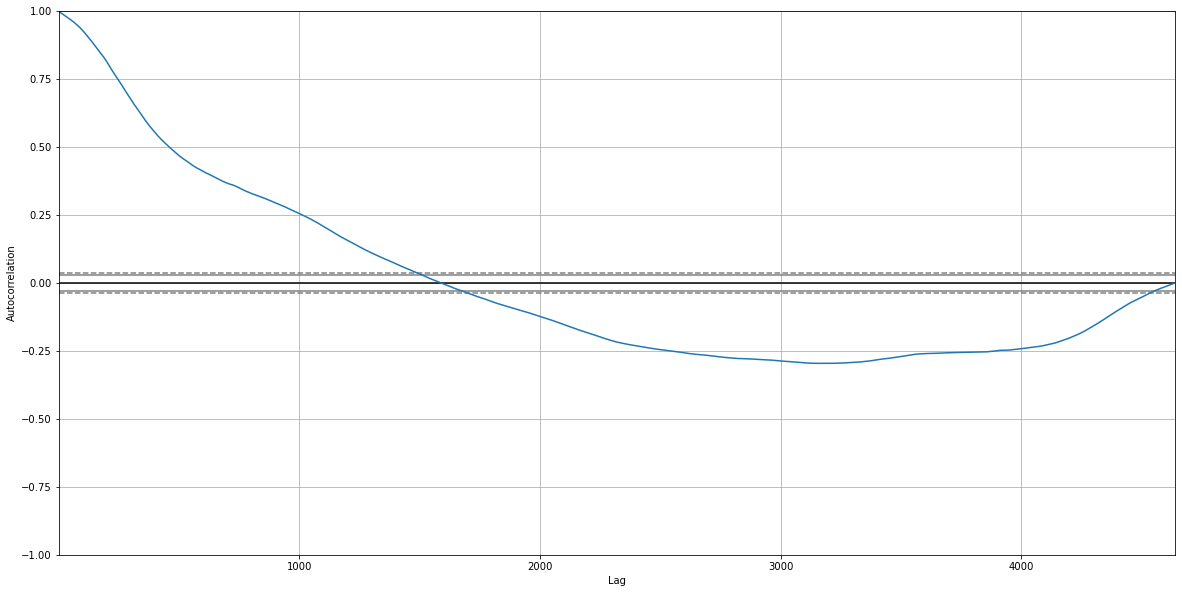

In [252]:
#SPRAWDZENIE AUTOKORELACJI

from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,10));
autocorrelation_plot(data)
plt.show()

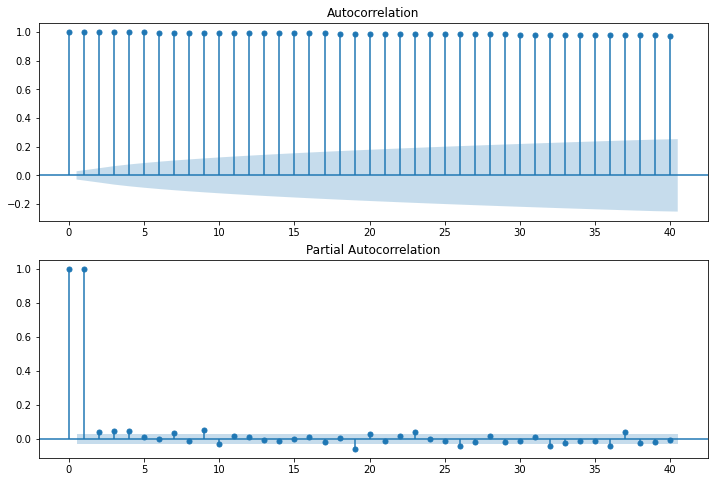

In [253]:
#SPRAWDZENIE AUTOKORELACJI

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.values, lags=40, ax=ax2)
plt.show()

In [254]:
scaler=MinMaxScaler(feature_range=(0,1))

data_scaled=scaler.fit_transform(data.values.reshape(-1,1))

In [255]:
test_size = 0.2

In [256]:
training_data_size = int(len(data_scaled)*(1-test_size))
test_data_size = len(data_scaled)-training_data_size

train_data= data_scaled[0:training_data_size,:]
test_data = data_scaled[training_data_size:len(data_scaled),:1]

print(training_data_size)
print(test_data_size)

3711
928


In [257]:
time_step = 21

In [258]:
def create_dataset(dataset, time_step=time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [259]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer ='adam', metrics=['mse', 'mae'])

model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
222/222 [==============================] - 14s 34ms/step - loss: 5.9471e-04 - mse: 5.9471e-04 - mae: 0.0146 - val_loss: 3.5964e-04 - val_mse: 3.5964e-04 - val_mae: 0.0161
Epoch 2/30
222/222 [==============================] - 6s 28ms/step - loss: 2.2257e-04 - mse: 2.2257e-04 - mae: 0.0105 - val_loss: 2.2786e-04 - val_mse: 2.2786e-04 - val_mae: 0.0116
Epoch 3/30
222/222 [==============================] - 6s 28ms/step - loss: 1.9431e-04 - mse: 1.9431e-04 - mae: 0.0098 - val_loss: 6.1715e-04 - val_mse: 6.1715e-04 - val_mae: 0.0221
Epoch 4/30
222/222 [==============================] - 6s 29ms/step - loss: 1.7179e-04 - mse: 1.7179e-04 - mae: 0.0093 - val_loss: 2.0718e-04 - val_mse: 2.0718e-04 - val_mae: 0.0110
Epoch 5/30
222/222 [==============================] - 6s 28ms/step - loss: 1.3664e-04 - mse: 1.3664e-04 - mae: 0.0083 - val_loss: 3.4405e-04 - val_mse: 3.4405e-04 - val_mae: 0.0142
Epoch 6/30
222/222 [==============================] - 7s 30ms/step - loss: 1.2654e-04 - mse: 1

In [288]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

29/29 [==============================] - 0s 11ms/step


In [289]:
train_predict_inverted = scaler.inverse_transform(train_predict)
test_predict_inverted = scaler.inverse_transform(test_predict)

test_predict_inverted_zeros = np.zeros(train_predict_inverted.shape[0])
test_predict_inverted_final= np.insert(test_predict_inverted, 0, test_predict_inverted_zeros)

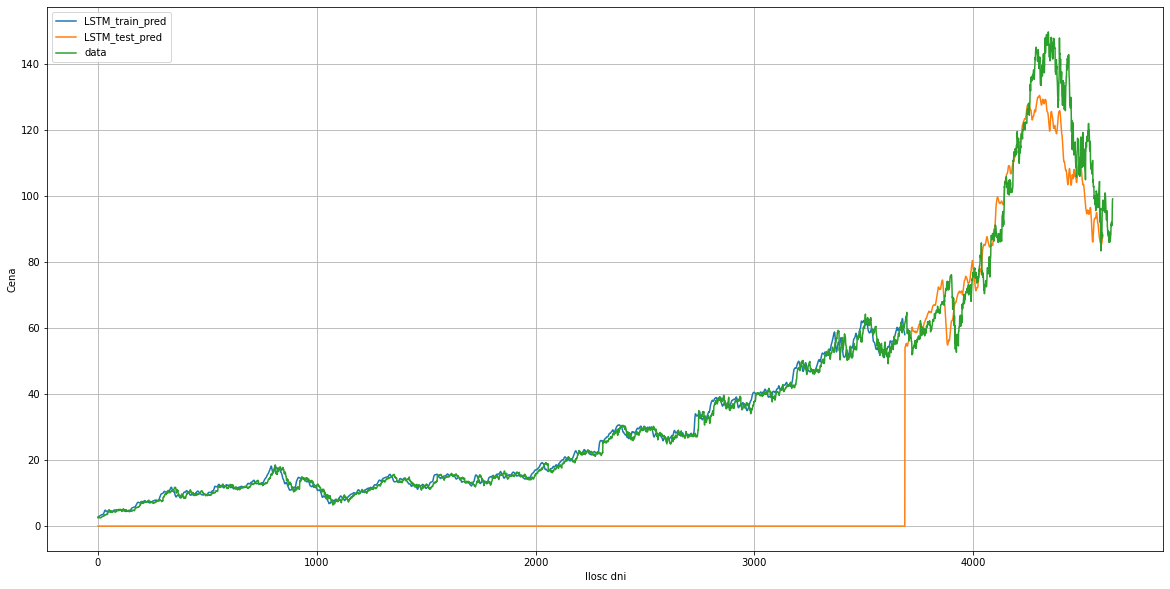

In [290]:
plt.figure(figsize=(20,10))
plt.plot(train_predict_inverted, label='LSTM_train_pred')
plt.plot(test_predict_inverted_final, label = 'LSTM_test_pred')
plt.plot(data.values, label= 'data')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc dni')
plt.ylabel('Cena')
plt.show()

In [363]:
lstm_mean_squared_error = metrics.mean_squared_error(X_test_pred, data.values[-test_data_size+time_step+1:])

lstm_mean_absolute_error = metrics.mean_absolute_error(X_test_pred, data.values[-test_data_size+time_step+1:])

lstm_median_absolute_error = metrics.median_absolute_error(X_test_pred, data.values[-test_data_size+time_step+1:])

lstm_explained_variance_score = metrics.explained_variance_score(X_test_pred, data.values[-test_data_size+time_step+1:])

lstm_r2 = metrics.r2_score(X_test_pred, data.values[-test_data_size+time_step+1:])

In [230]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [231]:
#PODZIAŁ DANYCH PRZED TRANSFORMACJĄ NA CZĘŚĆ TRENINGOWĄ ORAZ TESTOWĄ

data_values = data.values
data_train = data[:-test_data_size]
data_test = data[-test_data_size:]

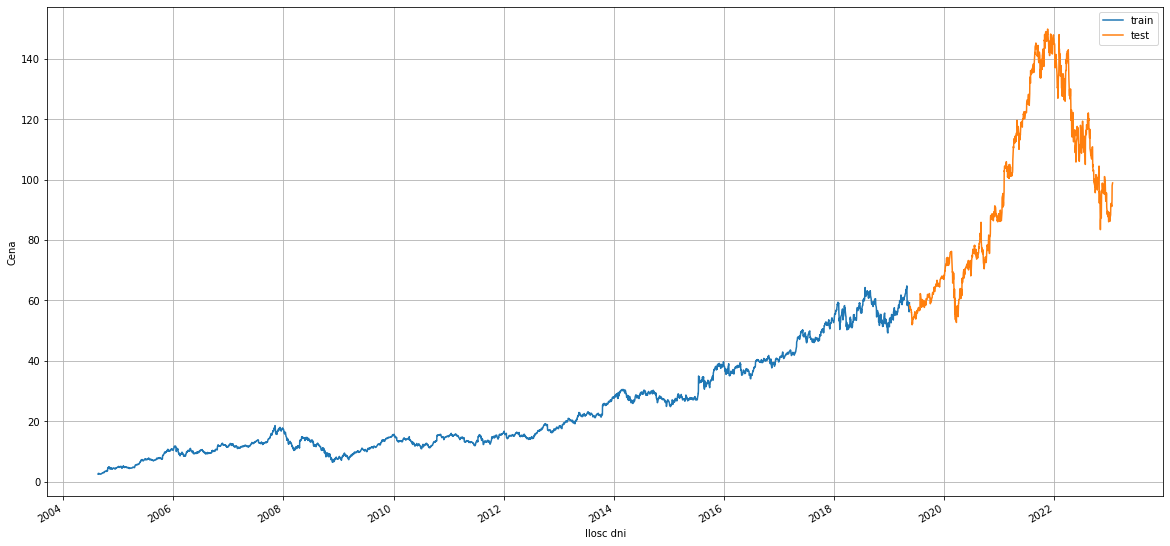

In [232]:
#NARYSOWANIE WYKRESU DLA DANYCH Z CZĘŚCI TRENIGOWEJ ORAZ TESTOWEJ PRZED TRANSFORMACJĄ

plt.figure(figsize=(20, 10))
data_train.plot(label = 'train')
data_test.plot(label = 'test')
plt.legend()
plt.grid()
plt.xlabel('Ilosc dni')
plt.ylabel('Cena')
plt.show()

In [233]:
#TRANSFORMACJA ZAIMPORTOWANYCH DANYCH SZEREGU CZASOWEGO

df = pd.DataFrame()
df['t'] = [x for x in data]
dataframe = series_to_supervised(df, time_step)
dataframe

,var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
21,2.511011,2.710460,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,...,2.542042,2.560060,2.560310,2.635886,2.690190,2.790040,2.802803,2.852102,2.940190,2.986987
22,2.710460,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,...,2.560060,2.560310,2.635886,2.690190,2.790040,2.802803,2.852102,2.940190,2.986987,2.948949
23,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,...,2.560310,2.635886,2.690190,2.790040,2.802803,2.852102,2.940190,2.986987,2.948949,2.962462
24,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,2.542042,...,2.635886,2.690190,2.790040,2.802803,2.852102,2.940190,2.986987,2.948949,2.962462,3.023524
25,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,2.542042,2.560060,...,2.690190,2.790040,2.802803,2.852102,2.940190,2.986987,2.948949,2.962462,3.023524,2.998749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4634,95.070000,90.860001,90.260002,88.440002,89.019997,89.580002,87.760002,89.230003,87.389999,86.019997,...,89.120003,88.080002,86.199997,87.339996,88.019997,88.419998,91.519997,91.129997,92.120003,91.290001
4635,90.860001,90.260002,88.440002,89.019997,89.580002,87.760002,89.230003,87.389999,86.019997,88.449997,...,88.080002,86.199997,87.339996,88.019997,88.419998,91.519997,91.129997,92.120003,91.290001,91.120003
4636,90.260002,88.440002,89.019997,89.580002,87.760002,89.230003,87.389999,86.019997,88.449997,88.230003,...,86.199997,87.339996,88.019997,88.419998,91.519997,91.129997,92.120003,91.290001,91.120003,93.050003
4637,88.440002,89.019997,89.580002,87.760002,89.230003,87.389999,86.019997,88.449997,88.230003,89.120003,...,87.339996,88.019997,88.419998,91.519997,91.129997,92.120003,91.290001,91.120003,93.050003,98.019997


In [234]:
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

In [235]:
#PODZIAŁ DANYCH NA CZĘŚĆ TESTOWĄ ORAZ TRENINGOWĄ

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [236]:
#DEFINIOWANIE PARAMETRÓW CROSS-VALIDATION

seed=123
kfold = model_selection.KFold(n_splits=5, random_state=None)

In [237]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ ELASTIC NET
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)
grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622.7179892856652, tolerance: 359.889999220696
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607.8363643455177, tolerance: 348.04550553958916
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.3486141335006, tolerance: 368.63798530188467
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4938.593856090528, tolerance: 363.3982385852305
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5161.574374842472, tolerance: 372.1225451566972
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4771.819344522722, tolerance: 359.889999220696
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conver

KeyboardInterrupt: 

In [ ]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ LASSO
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'lasso__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)
grid_2.fit(X_train, y_train)
grid_2.best_params_

In [ ]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ RIDGE
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'ridge__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)
grid_3.fit(X_train, y_train)
grid_3.best_params_

In [ ]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ REGRESJI WIELOMIANOWEJ
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]},
                    cv=kfold,
                    refit=True)
grid_4.fit(X_train, y_train)
grid_4.best_params_

In [ ]:
#TRENOWANIE MODELU MLP REGRESSOR 

grid_5 = GridSearchCV(MLPRegressor(hidden_layer_sizes=(100,100,100),activation='tanh',alpha=0.0001,max_iter=1000),
                    param_grid={'hidden_layer_sizes': [(1000,1000,1000),(100,100,100),(10,10,10)],
                                'alpha': [1, 10, 100 ,1000],
                               'activation': ['identity', 'logistic', 'tanh', 'relu']                               
                               },
                    cv = kfold,
                    n_jobs=1,
                    refit=True)
grid_5.fit(X_train,y_train)
grid_5.best_params_

In [ ]:
#UTWORZENIE LIST OPTYMALNYCH PARAMETRÓW R^2, VAR, MAE, MSE DLA WSZYSTKICH ANALIZOWANYCH METOD

from sklearn import  metrics

models = []

models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('LR', grid_4.best_estimator_))
models.append(('MLP_R', grid_5.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

In [ ]:
#UTWORZENIE DATAFRAME PARAMETRÓW R^2, VAR, MAE, MSE DLA WSZYSTKICH ANALIZOWANYCH METOD

d = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['ElasticNet','Lasso','Ridge', 'LR', 'MLP_R'])
df

In [ ]:
#WNIOSEK: WSZYSTKIE MODELE/ALGORYTMU ZWRÓCIŁY WARTOŚĆ R^2 WIĘKSZĄ OD 0.9 TYM SAMYM MOŻEMY UZNAĆ, ŻE WSZYSTKIE MODELE/ALGORYTMY W SPOSÓB ZADOWALAJĄCY PRZEWIDUJĄ WARTOŚCI Z DANYCH TESTOWYCH

In [ ]:
#FILTROWANIE DATAFRAME DLA MAKSYMALNEJ WARTOŚCI R^2 ODPOWIADAJĄCEJ NAJSKUTECZNIEMU MODELOWI/ALGORYTMOWI MAKSYMALNEJ WARTOŚCI R^2

df[df['r2'] == df['r2'].max()]

In [ ]:
data_train_zeros = np.zeros(data_train.values.shape[0])
data_test_chart= np.insert(data_test.values, 0, data_train_zeros)

In [ ]:
# NARYSOWANIE WYKRESU CZĘŚCI TRENINGOWEJ, TESTOWEJ ORAZ WSZYSTKICH NAUCZONYCH MODELI - MODELE PRZEWIDUJĄ OSTATNIE 925 OBSERWACJI Z CZĘŚCI TESTOWEJ

plt.figure(figsize=(20,10))
plt.plot(data_train.values, label = 'train')
plt.plot(data_test_chart, label = 'test')

all_data = []
for name, model in models: 
    data = np.zeros(data.shape[0], dtype=float)
    data.fill(np.nan)
    
    for i in range(1,test_data_size):
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
        
    all_data.append(data)
        
    plt.plot(data , label=name)
    plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc dni')
plt.ylabel('Cena')
plt.show()

#test_predict_inverted_zeros = np.zeros(train_predict_inverted.shape[0])
#test_predict_inverted_final= np.insert(test_predict_inverted, 0, test_predict_inverted_zeros)

In [ ]:
# NARYSOWANIE WYKRESU DLA CZĘŚCI TESTOWEJ NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,test_data_size):
        data_chart = data_test.values
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [ ]:
# NARYSOWANIE WYKRESU OSTATNICH 450 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,450):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [ ]:
# NARYSOWANIE WYKRESU OSTATNICH 225 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,225):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [ ]:
# NARYSOWANIE WYKRESU OSTATNICH 110 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,110):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [ ]:
# NARYSOWANIE WYKRESU OSTATNICH 55 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,55):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [ ]:
# NARYSOWANIE WYKRESU OSTATNICH 25 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,25):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [ ]:
# NARYSOWANIE WYKRESU OSTATNICH 12 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,12):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [ ]:
#WNIOSEK: POMIMO, IŻ ANALIZOWANE MODELE W SPOSÓB SATYSFAKCJONUJĄCY PRZEWIDUJĄ OBSERWACJE DLA DANYCH Z CZĘŚCI TESTOWEJ, NALEŻY PAMIĘTAĆ, IŻ MODEL PRZEWIDUJE WARTOŚCI NA PODSTAWIE OBSERWACJI Z DNIA POPRZEDNIEGO, MODEL JEST WRAŻLIWY NA WYDARZENIA NIESPODZIEWANE MAJĄCE NISKIE PRAWDOPODOBIEŃSTWO ORAZ WPROWADZAJĄCE DUŻĄ ZMIENNOŚĆ ANALIZOWANEGO WALORU/SPÓŁKI TZW. CZARNE ŁABĘDZIE